# Kachra Rani 
## Team:
### 1. Syed Hassan Haider
### 2. Inara Naseem G H Chagani 
### 3. Muhammad Shahrom Ali 

In [1]:
# Input: Image 
# Output : Label for that Image 

# Steps: 
# 1. Loading Image and Preprocessing 
# 2. Defining Model Architecture 
# 3. Training the Model 
# 4. Estimation of performance

###### Importing and Housekeeping stuff

In [2]:
#imports
import numpy as np 

import pickle

import cvxopt

import cv2

from sklearn import svm
from skimage import color

from skimage.feature import hog
from sklearn.metrics import classification_report,accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('fivethirtyeight')

#For GUI
from tkinter import *
import tkinter as tk
from win32api import GetSystemMetrics
from tkinter import messagebox
from tkinter import filedialog
from PIL import Image, ImageTk
import os

In [3]:
#FILENAMES FOR EXPORTED DATA 

FEATURE_DATA = 'KR_extracted_features'
RAW_DATASET = 'KR_dataset'
KR_MODEL = 'KR_model'

# Supporting information defined 
dataset_info = {
    # FORMAT::garbage_type : (no_of_imgs, label_value)
    'glass' : (501, 0),
    'plastic' : (482, 1),
    'cardboard' : (403, 2),
    'paper' : (594, 3),
    'metal' : (410, 4)
}

#Label_value (int) : garbage_type (string)
labels = {dataset_info[i][1] : i for i in dataset_info}

##### Helper Functions

In [4]:
#export files
def export(filename, to_export):
    np.save(filename + ".npy", to_export)

In [5]:
def load_data(filename):
    try:
        test_frame = np.load('./' + filename + ".npy", allow_pickle=True)
    except IOError:
        raise IOError
    finally:
        return test_frame

###### SVM Implementation

In [6]:
def gaussian(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x-z, axis=1)**2 / (2*(sigma**2)))

In [7]:
# Reference: Stanford Online: Support Vector Machines Lecture notes 3
# Andrew Ng

class KR_SVM():
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C
    
    #training the model
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        #m = number of entries
        #n = number of features
        m, n = X.shape
        
        #Calculate the Kernel
        self.K = np.zeros((m, m))
        
        for i in range(m):
            self.K[i,:] = self.kernel(X[i, np.newaxis], self.X)
            
        
        P = cvxopt.matrix(np.outer(y, y)*self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m)*-1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m)*self.C)))
        A = cvxopt.matrix(y, (1, m), 'd')
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        

    
    def predict(self, feat_desc):
        y_predict = np.zeros((self.X.shape[0]))
        sv = self.get_parameters(self.alphas)
        
        for i in range(self.X.shape[0]):
            y_predict[i] = np.sum(self.alphas[sv] * self.y[sv, np.newaxis] *
                                 self.kernel(self.X[i], self.X[sv])[:, np.newaxis])
        
        return np.sign(y_predict + self.b)
    def get_parameters(self, alphas):
        threshold = 1e-4
        
        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv]*self.y[sv, np.newaxis])
        self.b = np.mean(self.y[sv, np.newaxis] - 
                         self.alphas[sv] * self.y[sv, np.newaxis]*self.K[sv, sv][:, np.newaxis])
        
        return sv

###### Load Data

In [8]:
def preprocess_img(img):
    
    scale_percent = 50 # percent of original size
    
    #Resize the image for less pixels 
    width = int(256)
    height = int(192)
    dim = (width, height) 
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

    #convert image to grayscale 
    img = color.rgb2gray(img)
    
    return img

In [9]:
def load_dataset():
    KR_dataset = list()
    
    for garbage_type in dataset_info:
    
        img_count = dataset_info[garbage_type][0]
        garbage_label = dataset_info[garbage_type][1]
    
        #LOAD IMAGES OF SELECTED GARBAGE TYPE
        for i in range(1,  img_count + 1):

            img_path = './Dataset/' + garbage_type + "/" + garbage_type + str(i) + '.jpg'

            img = preprocess_img( mpimg.imread( img_path ) ) 

            KR_dataset.append((img, garbage_label))

    #Loaded Dataset
    KR_dataset = np.array(KR_dataset, dtype=object)
    
    return KR_dataset

###### Feature Extraction 

In [10]:
def feature_extraction(img):
    ppc = 16 #PIXELS PER CEL 
    return hog(img, 
               orientations=8,
               pixels_per_cell=(ppc,ppc),
               cells_per_block=(4, 4),
               block_norm= 'L2',
               visualize=True)

In [11]:
def gen_feature_set(dataset):
    #Feature Extraction using Histogram of Gradient
    
    hog_images = []
    hog_features = []

    for image in dataset:

        feat_desc, hog_image = feature_extraction(image[0])

        hog_images.append(hog_image)
        hog_features.append(feat_desc)
    
    hog_features = np.array(hog_features)
    labels = np.array( [img[1] for img in dataset] ).reshape(len(dataset), 1) #make collumn vector

    # each row corresponds to hog_features of some img i
    # and at the end is the label of that image 
    data_frame = np.hstack((hog_features, labels))
    
    return data_frame

###### Splitting Data

In [12]:
def split_data(data_frame):
    
    percentage = 80
    partition = int(data_frame.shape[0]*percentage/100)
    
    x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
    
    y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()
    
    return (x_train, y_train, x_test, y_test)

###### Generating Model

In [13]:
def KR_classifier(x_train, y_train):    
    # Own implementation
    model_kr = KR_SVM()
    model_kr.fit(x_train,y_train)
    
    return model_kr

In [14]:
def LIB_classifier(x_train, y_train):    
    # Lib implementation
    model_kr = svm.SVC()
    model_kr.fit(x_train,y_train)
    
    return model_kr

###### Predictions and Model Evaluation

In [15]:
def model_eval(y_test, y_pred):
    numerator = 0
    denomenator = len(y_test)
    for i in range(denomenator):
        if y_test[i] == y_pred[i]:
            numerator += 1
    
    print("Accuracy: " + str(numerator / denomenator * 100) + "%")
#     print("Accuracy: " + str(accuracy_score(y_test, y_pred) * 100) + "\%")
#     print('\n')
#     print(classification_report(y_test, y_pred))

###### Generate Model

In [16]:
# Load Dataset 
KR_dataset = load_dataset()
print("Dataset Loaded...")

# # Export Dataset
# export(RAW_DATASET, KR_dataset)

# Shuffle Dataset
np.random.shuffle(KR_dataset)

# Extract Features and Create Feature Set
KR_data_frame = gen_feature_set(KR_dataset)
print("Featureset generated...")

# # Export Feature Set 
# export(FEATURE_DATA, KR_data_frame)

# Split Feature Set 
x_train, y_train, x_test, y_test = split_data(KR_data_frame)

Dataset Loaded...
Featureset generated...


In [17]:
# Fit Model
LIB_model = LIB_classifier(x_train, y_train)
print("Library Model Loaded...")

Library Model Loaded...


In [18]:
# Fit Model
KR_model = KR_classifier(x_train, y_train)
print("KR Model Loaded...")

KR Model Loaded...


In [19]:
#Test KR Model
y_pred_KR = KR_model.predict(x_test)

In [20]:
#Test KR Model
y_pred_LIB = LIB_model.predict(x_test)

In [21]:
# Metrics on Model
print("Accuracy of own model")
model_eval(y_test, y_pred_KR)

print("Accuracy of Library model")
model_eval(y_test, y_pred_LIB)

Accuracy of own model
Accuracy: 21.548117154811717%
Accuracy of Library model
Accuracy: 60.46025104602511%


###### Run Model

In [22]:
# Model takes image, returns label
def Lib_Rani(img_path):
    img_run = mpimg.imread(img_path)
    plt.imshow(img_run)
    plt.show()

    img_run = preprocess_img(img_run) 

    feature_descriptor = np.array([feature_extraction(img_run)[0],])
    predicted_label = LIB_model.predict(feature_descriptor)

    print("I think this is ", labels[predicted_label[0]])
    
    return predicted_label[0]

In [23]:
# Model takes image, returns label
def Kachra_Rani(img_path):
    img_run = mpimg.imread(img_path)
    plt.imshow(img_run)
    plt.show()

    img_run = preprocess_img(img_run) 

    feature_descriptor = np.array([feature_extraction(img_run)[0],])
    predicted_label = KR_model.predict(feature_descriptor)

    print("Ye", labels[predicted_label[0]], "hai, Dirtoo!")
    
    return predicted_label[0]

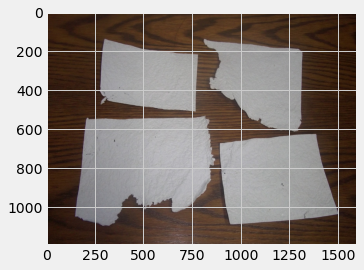

I think this is  cardboard


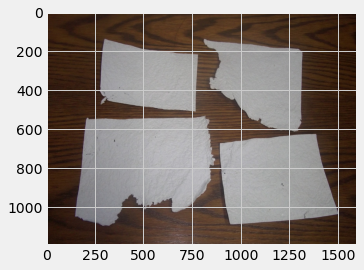

Ye glass hai, Dirtoo!


0.0

In [24]:
# Run model

#load image in img 
trash_imgs_count = 10

# for i in range(1, trash_imgs_count + 1):
#     img_path = "./Dataset/trash/trash"+ str(i) +".jpg"
    
#     Kachra_Rani(img_path)
#     Lib_Rani(img_path)

    
Lib_Rani("./cardboard_torn.jpg")
Kachra_Rani("./cardboard_torn.jpg")

###### GUI

filename: D:/Documents/GitHub/Kachra-Rani/plastic.jpg


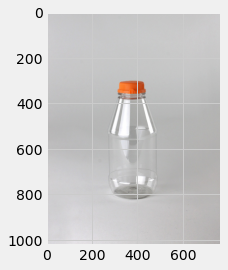

I think this is  plastic


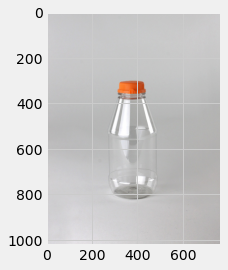

Ye glass hai, Dirtoo!


In [25]:
root = Tk()
root.title("Kachra Rani") 
#root.geometry("700x400+200+50") #Width x Height

default_w = 1366
default_h = 768

screen_w = GetSystemMetrics(0)
screen_h = GetSystemMetrics(1)

load = Image.open("./GUI/GUI_Logo_recycle.png")
load = load.resize((int(150 * default_w/screen_w), int(150 * default_h / screen_h)), Image.ANTIALIAS)
render = ImageTk.PhotoImage(load)
img = Label(image=render)
img.image = render
img.configure(bg="white")

img.place(x=screen_w // 3,y=0)

class FullScreenApp(object):
    def __init__(self, master, **kwargs):
        self.master=master
        pad=3
        self._geom='200x200+0+0'
        master.geometry("{0}x{1}+0+0".format(
            master.winfo_screenwidth()-pad, master.winfo_screenheight()-pad))
        master.bind('<Escape>',self.toggle_geom)            
    def toggle_geom(self,event):
        geom=self.master.winfo_geometry()
        print(geom,self._geom)
        self.master.geometry(self._geom)
        self._geom=geom
        
        
app=FullScreenApp(root)
window = root
frm = Frame(window, highlightbackground="black", highlightcolor="black", highlightthickness="2", bd= 0)
frm.configure(bg="white")
frm.pack(side=BOTTOM, padx=15, pady=50)
#set window color
window.configure(bg='white',highlightbackground="#00c100", highlightcolor="#00c100", highlightthickness="20", bd= 0)

filename = ""

def showimage():
    fln = filedialog.askopenfilename(initialdir=os.getcwd(), title="Select Image File", filetypes=(("JPG File",".jpg"),("PNG File",".png"),("All Files",".")))
    #global filename
    #filename = fln
    print("filename:",fln)
    img = Image.open(fln)
    img.thumbnail((350,350))
    img = ImageTk.PhotoImage(img)
    lbl.configure(image=img, bg="white")
    lbl.image = img
    lbl.place(x=450,y=200)
    idx = Lib_Rani(fln)
    idx2 = Kachra_Rani(fln)
    message1 = "Library Implementation: Ye " + labels[idx] + " hai, Dirtoo!"
    message2 = "Manual Implementation: Ye " + labels[idx2] + " hai, Dirtoo!"
    messagebox.showinfo("Analysis",message1+message2)

label = tk.Label(
    text="Kachra Rani",
    foreground="black",  # Set the text color to white
    background="white",  # Set the background color to black
    font='Helvetica 24 bold'
)

lbl = Label(window)
lbl.pack()
btn = Button(frm, text="Browse Image",bg="white", command=showimage)
btn.pack(side=TOP, padx=17, pady=17)

label.pack(side=TOP, padx=17, pady=17)


window.mainloop()
